In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Deep learning/deep_learning')
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1JCIWhI2EEnh4FhnlYt0fPfvauIBPufyL/deep_learning'

In [4]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tempfile import TemporaryDirectory
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

cudnn.benchmark = True
plt.ion()   # interactive mode

#loading models

import torchvision.models as models


Finetuning the SqueezeNet: Instead of random initialization, we initialize the network with a pretrained network. Rest of the training looks as usual.

SqueezeNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

Fine tuning SqueezeNet

In [ ]:
# !unzip './data/transfer_6394502_files_0a0e2750/UCMerced.zip'

In [5]:
!ls

 data
 DeepLearning_TransferLearning_RockClassification.ipynb
 DeepLearning_TransferLearning_Satellite.ipynb
' LEILA_DeepLearning_Fine_tuning.ipynb'
 LEILA_DeepLearning_TransferLearning_Satellite.ipynb
 UCMerced


In [6]:


# actual path where the dataset is stored
data_dir = './UCMerced/'

# Define the transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))#All pre-trained models expect input images normalized in the same way
])

# Load training dataset
train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load validation dataset
val_dataset = datasets.ImageFolder(root=data_dir + '/val', transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load test dataset
test_dataset = datasets.ImageFolder(root=data_dir + '/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)




In [ ]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 1050
    Root location: ./UCMerced//train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
           )

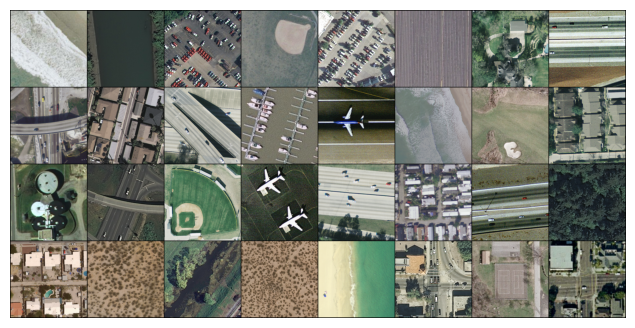

In [7]:
# Visualizing the data
from torchvision.utils import make_grid

def show_images(img):
    #img = (img - img.min())/(img.max()-img.min())
    npimg = img.numpy()
    plt.figure(figsize=(8*4,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(make_grid(images))

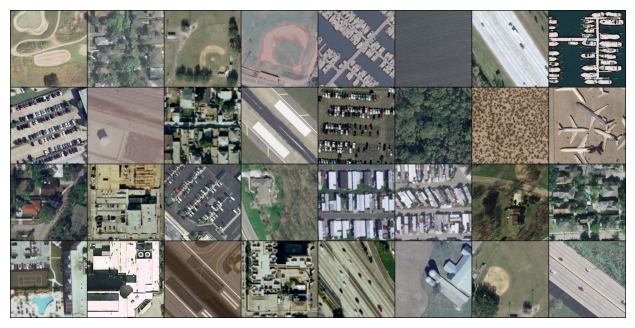

In [8]:
images, labels = next(dataiter)
show_images(make_grid(images))

In [ ]:
#activating CUDA
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


 general function to train a model

In [10]:
dataloaders={'train':train_loader,'val':val_loader,'test':test_loader}
dataset_sizes={'train':len(train_dataset),'val':len(val_dataset),'test':len(test_dataset)}

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=40):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model_conv = models.squeezenet1_1(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.classifier[1]=nn.Conv2d(512,21,kernel_size=(1,1))
model_conv.num_classes=21

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

NameError: ignored